In [1]:
import matplotlib
matplotlib.use("nbagg")

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from utility import *
from models import *

In [2]:
import math

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import Tensor

import torch.optim as optim
import torch.nn.functional as F

In [3]:
from os import listdir
from os.path import isfile, join
import numpy as np

polycube_path = "/Users/davidcleres/DeepShape/Polycubing-Automated/Generated-Cars/"
polycube_files = [f for f in listdir(polycube_path) if isfile(join(polycube_path, f))]

voxelized_mesh_path = "/Users/davidcleres/DeepShape/Polycubing-Automated/voxelizedMeshes/"
voxelized_mesh_files = [f for f in listdir(voxelized_mesh_path) if isfile(join(voxelized_mesh_path, f))]

voxelizedFiles = []
polycubedFiles = []

for f in voxelized_mesh_files: 
    if f[-13:] == "voxelized.txt":
        voxelizedFiles = np.hstack((voxelizedFiles, f))
    
for f in polycube_files:
    if f[-14:] == "finalCubes.txt":
        polycubedFiles = np.hstack((polycubedFiles, f))

# Define the global parameters 

In [4]:
grid_size=32
batch_size=15

### Save the tensor to a text file 

In [5]:
voxelized_train_input, polycube_target=loadData(grid_size, polycube_path, voxelized_mesh_path, voxelizedFiles, polycubedFiles, loadFromScratch=True)

<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch

# Load Data

In [6]:
preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target = preprocessing_train(voxelized_train_input, polycube_target,batch_size, False, False)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train)
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation)
preprocessed_input_train_target = torch.from_numpy(preprocessed_input_train_target)
preprocessed_input_validation_target = torch.from_numpy(preprocessed_input_validation_target)

Ntrain = len(preprocessed_input_train[:, 0,0,0,0]) 
Nvalidation = len(preprocessed_input_validation[:,0,0,0,0])

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, grid_size, grid_size, grid_size).float())
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, grid_size, grid_size, grid_size).float())

labels_train = preprocessed_input_train_target.float()
labels_validation = preprocessed_input_validation_target.float()

print('train', train_input.shape)
print('validation', validation_input.shape)
print('train_target', labels_train.shape)
print('validation_target', labels_validation.shape)

train torch.Size([45, 1, 32, 32, 32])
validation torch.Size([15, 1, 32, 32, 32])
train_target torch.Size([45, 32, 32, 32])
validation_target torch.Size([15, 32, 32, 32])


# Network initialization

In [7]:
# Train network 
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(preprocessed_input_train_target).long()  # keep long tensors
    validation_target = Variable(preprocessed_input_validation_target, volatile=True).long() # convert to float
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(preprocessed_input_train_target)  # keep long tensors
    validation_target = Variable(preprocessed_input_validation_target, volatile=True) # convert to float
    Noutputs = 2
    
else:
    train_target = Variable(preprocessed_input_train_target.float()) # convert to float
    validation_target = Variable(preprocessed_input_validation_target.float(), volatile=True ) # convert to float
    Noutputs = 1
    
Nbatches = int(math.ceil(Ntrain/batch_size)) #batch_size is defined above
Nepochs = 250
Nrep = 1
        
#model = conv3DNet(grid_size, Noutputs, batch_size)
#model = conv3DNet(grid_size, Noutputs, batch_size)
#model = conv3DNet(grid_size, Noutputs, batch_size)
#model = conv3DNet(grid_size, Noutputs, batch_size)
model = UnetGenerator_3d(in_dim=1, out_dim=Noutputs, num_filter=4)

#optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.90)
optimizer = optim.Adam(model.parameters())
#optimizer = optim.Adagrad(model.parameters())
#optimizer = optim.Adamax(model.parameters())
#optimizer = optim.ASGD(model.parameters())
#optimizer = optim.RMSprop(model.parameters())
#optimizer = optim.Rprop(model.parameters())
 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True) #Reduces the learning rate if it did not decreased by more than 10^-4 in 10 steps

train_errors = torch.Tensor(Nepochs).zero_()
validation_errors = torch.Tensor(Nepochs).zero_()

ep_loss = torch.Tensor(Nepochs).zero_()

for i_ep in range(Nepochs):
    for b_start in range(0, Ntrain, batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
        model.train()
        model.zero_grad()
        output = model(train_input.narrow(0, b_start, bsize_eff))
        if isinstance(criterion, nn.CrossEntropyLoss) or isinstance(criterion, nn.NLLLoss):
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))
        else:
            #if delta model is chosen
            #batch_loss = criterion(output.view(bsize_eff*Noutputs), train_target.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output.view(bsize_eff,grid_size,grid_size,grid_size), train_target.narrow(0, b_start, bsize_eff))
        ep_loss[i_ep] += batch_loss.data[0]
        batch_loss.backward()
        optimizer.step()

    scheduler.step(ep_loss[i_ep])

    nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size, criterion)
    nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size, criterion)

    Ntrain_nb = Ntrain*grid_size**3
    Nvalidation_nb = Nvalidation*grid_size**3
    print("Epoch Number : ", i_ep)
    print("\t Training accuracy: ", (100*(Ntrain_nb-nb_train_errs)/Ntrain_nb))
    print("\t Validation accuracy ",(100*(Nvalidation_nb-nb_validation_errs)/Nvalidation_nb))

    print("\t Epoch Loss ", ep_loss[i_ep])

    train_errors[i_ep] = nb_train_errs
    validation_errors[i_ep] = nb_validation_errs


------Initiating U-Net------

Epoch Number :  0
	 Training accuracy:  41.99883355034722
	 Validation accuracy  41.694742838541664
	 Epoch Loss  2.123506546020508
Epoch Number :  1
	 Training accuracy:  42.23985460069444
	 Validation accuracy  41.882527669270836
	 Epoch Loss  2.0980615615844727
Epoch Number :  2
	 Training accuracy:  56.718410915798614
	 Validation accuracy  56.4117431640625
	 Epoch Loss  2.0866212844848633
Epoch Number :  3
	 Training accuracy:  54.758029513888886
	 Validation accuracy  54.385986328125
	 Epoch Loss  2.079710006713867
Epoch Number :  4
	 Training accuracy:  43.108791775173614
	 Validation accuracy  42.102254231770836
	 Epoch Loss  2.0749034881591797
Epoch Number :  5
	 Training accuracy:  39.026217990451386
	 Validation accuracy  37.827962239583336
	 Epoch Loss  2.0715861320495605
Epoch Number :  6
	 Training accuracy:  40.49079047309028
	 Validation accuracy  39.708658854166664
	 Epoch Loss  2.069072723388672
Epoch Number :  7
	 Training accuracy:  41

Epoch Number :  62
	 Training accuracy:  98.44584147135417
	 Validation accuracy  96.89168294270833
	 Epoch Loss  1.9506983757019043
Epoch Number :  63
	 Training accuracy:  97.3291015625
	 Validation accuracy  96.16312662760417
	 Epoch Loss  1.9487462043762207
Epoch Number :  64
	 Training accuracy:  98.4478759765625
	 Validation accuracy  97.19828287760417
	 Epoch Loss  1.9473358392715454
Epoch Number :  65
	 Training accuracy:  97.97234429253473
	 Validation accuracy  96.74702962239583
	 Epoch Loss  1.947324514389038
Epoch Number :  66
	 Training accuracy:  97.69761827256944
	 Validation accuracy  96.65852864583333
	 Epoch Loss  1.9427998065948486
Epoch Number :  67
	 Training accuracy:  98.00048828125
	 Validation accuracy  96.65873209635417
	 Epoch Loss  1.939400315284729
Epoch Number :  68
	 Training accuracy:  98.07325575086806
	 Validation accuracy  96.57999674479167
	 Epoch Loss  1.9371016025543213
Epoch Number :  69
	 Training accuracy:  98.01751030815973
	 Validation accurac

Epoch Number :  125
	 Training accuracy:  98.29739040798611
	 Validation accuracy  96.2933349609375
	 Epoch Loss  1.8521549701690674
Epoch Number :  126
	 Training accuracy:  98.74484592013889
	 Validation accuracy  96.5924072265625
	 Epoch Loss  1.8507193326950073
Epoch Number :  127
	 Training accuracy:  98.34058973524306
	 Validation accuracy  96.256103515625
	 Epoch Loss  1.848457932472229
Epoch Number :  128
	 Training accuracy:  98.43024359809027
	 Validation accuracy  96.407470703125
	 Epoch Loss  1.8459522724151611
Epoch Number :  129
	 Training accuracy:  98.59110514322917
	 Validation accuracy  96.44999186197917
	 Epoch Loss  1.8436369895935059
Epoch Number :  130
	 Training accuracy:  98.36568196614583
	 Validation accuracy  96.35965983072917
	 Epoch Loss  1.8423165082931519
Epoch Number :  131
	 Training accuracy:  98.807373046875
	 Validation accuracy  96.54703776041667
	 Epoch Loss  1.8403970003128052
Epoch Number :  132
	 Training accuracy:  98.45967610677083
	 Validatio

Epoch Number :  187
	 Training accuracy:  99.09322102864583
	 Validation accuracy  96.68904622395833
	 Epoch Loss  1.7694711685180664
Epoch Number :  188
	 Training accuracy:  99.09220377604167
	 Validation accuracy  96.7010498046875
	 Epoch Loss  1.7686221599578857
Epoch Number :  189
	 Training accuracy:  99.11600748697917
	 Validation accuracy  96.724853515625
	 Epoch Loss  1.7681186199188232
Epoch Number :  190
	 Training accuracy:  99.17955186631944
	 Validation accuracy  96.73482259114583
	 Epoch Loss  1.7674415111541748
Epoch Number :  191
	 Training accuracy:  99.03822157118056
	 Validation accuracy  96.69514973958333
	 Epoch Loss  1.7663731575012207
Epoch Number :  192
	 Training accuracy:  99.28331163194444
	 Validation accuracy  96.7822265625
	 Epoch Loss  1.7659249305725098
Epoch Number :  193
	 Training accuracy:  98.89010959201389
	 Validation accuracy  96.67765299479167
	 Epoch Loss  1.7647724151611328
Epoch Number :  194
	 Training accuracy:  99.21834309895833
	 Validat

Epoch Number :  249
	 Training accuracy:  98.91743977864583
	 Validation accuracy  96.844482421875
	 Epoch Loss  1.6981385946273804


In [8]:
print(train_target.shape)

torch.Size([45, 32, 32, 32])


In [9]:
print(train_target[44,:,:,:])

Variable containing:
(0 ,.,.) = 
   1   1   1  ...    1   1   1
   1   1   1  ...    1   1   1
   1   1   1  ...    1   1   1
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(1 ,.,.) = 
   1   1   1  ...    1   1   1
   1   1   1  ...    1   1   1
   1   1   1  ...    1   1   1
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(2 ,.,.) = 
   1   1   1  ...    1   1   1
   1   1   1  ...    1   1   1
   1   1   1  ...    1   1   1
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
...

(29,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(30,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0

#### 

In [10]:
print(output.shape)

torch.Size([15, 2, 32, 32, 32])


In [11]:
print(output[14,1,:,:,:])

Variable containing:
(0 ,.,.) = 
  0.9290  0.9952  0.9977  ...   0.9898  0.9935  0.9924
  0.9859  0.9975  0.9958  ...   0.9939  0.9949  0.9823
  0.9882  0.9979  0.9949  ...   0.9961  0.9929  0.9468
           ...             ⋱             ...          
  0.4597  0.4598  0.4601  ...   0.4590  0.4595  0.4591
  0.4610  0.4623  0.4620  ...   0.4622  0.4638  0.4625
  0.4575  0.4566  0.4566  ...   0.4567  0.4567  0.4576

(1 ,.,.) = 
  0.9775  0.9980  0.9987  ...   0.9885  0.9967  0.9940
  0.9909  0.9990  0.9987  ...   0.9932  0.9973  0.9950
  0.9895  0.9976  0.9971  ...   0.9966  0.9959  0.9833
           ...             ⋱             ...          
  0.4594  0.4568  0.4577  ...   0.4575  0.4558  0.4575
  0.4593  0.4572  0.4581  ...   0.4579  0.4578  0.4595
  0.4559  0.4533  0.4535  ...   0.4535  0.4537  0.4554

(2 ,.,.) = 
  0.9848  0.9972  0.9984  ...   0.9870  0.9912  0.9920
  0.9928  0.9982  0.9970  ...   0.9947  0.9964  0.9920
  0.9918  0.9970  0.9950  ...   0.9965  0.9950  0.9823
      

In [12]:
training_accuracy = np.array(100*(Ntrain_nb-train_errors)/Ntrain_nb)
validation_accurcy = np.array(100*(Nvalidation_nb-validation_errors)/Nvalidation_nb)

<IPython.core.display.Javascript object>


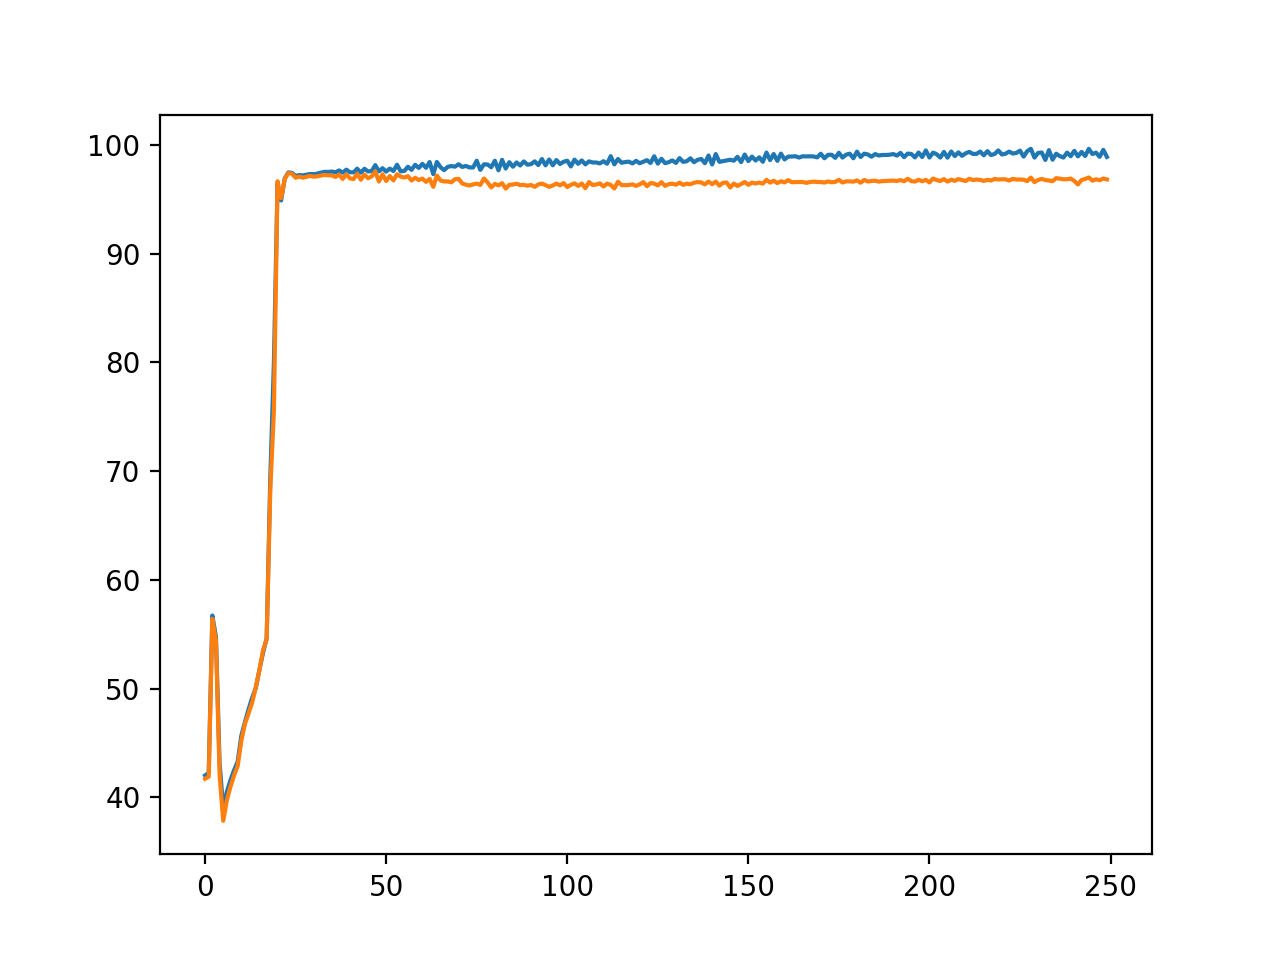

In [13]:
plt.plot(training_accuracy)
plt.plot(validation_accurcy)
plt.show()

In [14]:
'''voxels = np.array(output[4,:,:,:])

# and plot everything
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.voxels(voxels)
fig.savefig('VoxelizedFinal.png')
fig.show()'''

"voxels = np.array(output[4,:,:,:])\n\n# and plot everything\nfig = plt.figure(figsize=(10,10))\nax = fig.gca(projection='3d')\nax.voxels(voxels)\nfig.savefig('VoxelizedFinal.png')\nfig.show()"

In [15]:
'''def summary(input_size, model):
        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split('.')[-1].split("'")[0]
                module_idx = len(summary)

                m_key = '%s-%i' % (class_name, module_idx+1)
                summary[m_key] = OrderedDict()
                summary[m_key]['input_shape'] = list(input[0].size())
                summary[m_key]['input_shape'][0] = -1
                summary[m_key]['output_shape'] = list(output.size())
                summary[m_key]['output_shape'][0] = -1

                params = 0
                if hasattr(module, 'weight'):
                    params += th.prod(th.LongTensor(list(module.weight.size())))
                    if module.weight.requires_grad:
                        summary[m_key]['trainable'] = True
                    else:
                        summary[m_key]['trainable'] = False
                if hasattr(module, 'bias'):
                    params +=  th.prod(th.LongTensor(list(module.bias.size())))
                summary[m_key]['nb_params'] = params
                
            if not isinstance(module, nn.Sequential) and \
               not isinstance(module, nn.ModuleList) and \
               not (module == model):
                hooks.append(module.register_forward_hook(hook))
                
        dtype = th.cuda.FloatTensor
        
        # check if there are multiple inputs to the network
        if isinstance(input_size[0], (list, tuple)):
            x = [Variable(th.rand(1,*in_size)).type(dtype) for in_size in input_size]
        else:
            x = Variable(th.rand(1,*input_size)).type(dtype)
            
        print(x.shape)
        print(type(x[0]))
        # create properties
        summary = OrderedDict()
        hooks = []
        # register hook
        model.apply(register_hook)
        # make a forward pass
        model(x)
        # remove these hooks
        for h in hooks:
            h.remove()

        print('----------------------------------------------------------------')
        line_new = '{:>20}  {:>25} {:>15}'.format('Layer (type)', 'Output Shpae', 'Param #')
        print(line_new)
        print('================================================================')
        total_params = 0
        trainable_params = 0
        for layer in summary:
            ## input_shape, output_shape, trainable, nb_params
            line_new = '{:>20}  {:>25} {:>15}'.format(layer, summary[layer]['output_shape'], summary[layer]['nb_params'])
            total_params += summary[layer]['nb_params']
            if 'trainable' in summary[layer]:
                if summary[layer]['trainable'] == True:
                    trainable_params += summary[layer]['nb_params']
            print(line_new)
        print('================================================================')
        print('Total params: ' + str(total_params))
        print('Trainable params: ' + str(trainable_params))
        print('Non-trainable params: ' + str(total_params - trainable_params))
        print('----------------------------------------------------------------')
        return summary'''

'def summary(input_size, model):\n        def register_hook(module):\n            def hook(module, input, output):\n                class_name = str(module.__class__).split(\'.\')[-1].split("\'")[0]\n                module_idx = len(summary)\n\n                m_key = \'%s-%i\' % (class_name, module_idx+1)\n                summary[m_key] = OrderedDict()\n                summary[m_key][\'input_shape\'] = list(input[0].size())\n                summary[m_key][\'input_shape\'][0] = -1\n                summary[m_key][\'output_shape\'] = list(output.size())\n                summary[m_key][\'output_shape\'][0] = -1\n\n                params = 0\n                if hasattr(module, \'weight\'):\n                    params += th.prod(th.LongTensor(list(module.weight.size())))\n                    if module.weight.requires_grad:\n                        summary[m_key][\'trainable\'] = True\n                    else:\n                        summary[m_key][\'trainable\'] = False\n                i